In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from pprint import pprint

In [2]:
data = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')
data.shape

(5909, 192)

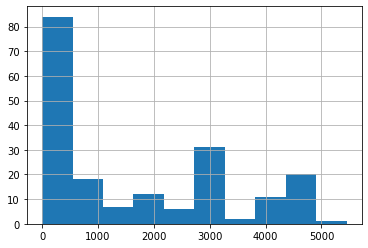

In [3]:
data.isnull().sum().hist()

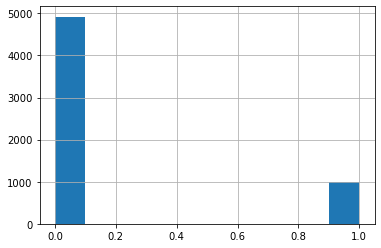

In [4]:
data['match'].hist()

In [5]:
# if you haven't installed xgboost on your system, uncomment the line below
# !pip install xgboost
# if you haven't installed bayesian-optimization on your system, uncomment the line below
!pip install scikit-optimize

In [6]:
x = data.drop('match', axis=1)
features_numeric = list(x.select_dtypes(include=['float64']))
features_categorical = list(x.select_dtypes(include=['object']))
y = data['match']

In [7]:
print(features_categorical)

['field', 'undergra', 'mn_sat', 'tuition', 'from', 'zipcode', 'income', 'career']


In [8]:
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost.sklearn import XGBClassifier

np.random.seed(0)

transformer_numeric = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())]
)

transformer_categorical = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', transformer_numeric, features_numeric),
        ('cat', transformer_categorical, features_categorical)
    ]
)

full_pipline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('my_classifier', XGBClassifier(
            objective='binary:logistic', seed=1))
    ]
)



# `__` denotes attribute 
# (e.g. my_classifier__n_estimators means the `n_estimators` param for `my_classifier`
#  which is our xgb)
param_grid = {
    'preprocessor__num__imputer__strategy': ['mean'],
    'my_classifier__n_estimators': [10, 20, 100],
    'my_classifier__max_depth':[10, 20]
}

grid_search = GridSearchCV(
    full_pipline, param_grid, cv=5, verbose=3, n_jobs=2, 
    scoring='roc_auc')

grid_search.fit(x, y)

print('best score {}'.format(grid_search.best_score_))
print('best score {}'.format(grid_search.best_params_))

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:   33.6s finished


best score 0.8771809088605341
best score {'my_classifier__max_depth': 10, 'my_classifier__n_estimators': 100, 'preprocessor__num__imputer__strategy': 'mean'}


In [9]:
# prepare submission:
submission = pd.DataFrame()
submission['id'] = data_test['id']
submission['match'] = grid_search.predict_proba(data_test)[:,1]
submission.to_csv('sample_submission_walkthrough.csv', index=False)
submission

,id,match
0,934,0.001090
1,6539,0.681770
2,6757,0.105092
3,2275,0.002627
4,1052,0.005981
...,...,...
2464,7982,0.007812
2465,7299,0.757996
2466,1818,0.037719
2467,937,0.001178


In [13]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.svm import SVC


SVC_pipline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('my_svc', SVC(class_weight='balanced'))
    ]
)
# SVC has a class_weight attribute for unbalanced data


# define ranges for bayes search
bayes_search = BayesSearchCV(
    SVC_pipline,
    {
        'my_svc__C': Real(1e-6, 1e+6, prior='log-uniform'),
        'my_svc__gamma': Real(1e-6, 1e+1, prior='log-uniform'),
        'my_svc__degree': Integer(1,8),
        'my_svc__kernel': Categorical(['linear', 'poly', 'rbf']),
    },
    n_iter=3,
    random_state=0,
    verbose=3,
)

bayes_search.fit(x, y)



Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] my_svc__C=2.352718564818733, my_svc__degree=6, my_svc__gamma=0.022854318128961743, my_svc__kernel=poly 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  my_svc__C=2.352718564818733, my_svc__degree=6, my_svc__gamma=0.022854318128961743, my_svc__kernel=poly, score=0.830, total=   7.8s
[CV] my_svc__C=2.352718564818733, my_svc__degree=6, my_svc__gamma=0.022854318128961743, my_svc__kernel=poly 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.8s remaining:    0.0s


[CV]  my_svc__C=2.352718564818733, my_svc__degree=6, my_svc__gamma=0.022854318128961743, my_svc__kernel=poly, score=0.812, total=   6.0s
[CV] my_svc__C=2.352718564818733, my_svc__degree=6, my_svc__gamma=0.022854318128961743, my_svc__kernel=poly 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.8s remaining:    0.0s


[CV]  my_svc__C=2.352718564818733, my_svc__degree=6, my_svc__gamma=0.022854318128961743, my_svc__kernel=poly, score=0.818, total=   6.1s
[CV] my_svc__C=2.352718564818733, my_svc__degree=6, my_svc__gamma=0.022854318128961743, my_svc__kernel=poly 
[CV]  my_svc__C=2.352718564818733, my_svc__degree=6, my_svc__gamma=0.022854318128961743, my_svc__kernel=poly, score=0.821, total=   9.3s
[CV] my_svc__C=2.352718564818733, my_svc__degree=6, my_svc__gamma=0.022854318128961743, my_svc__kernel=poly 
[CV]  my_svc__C=2.352718564818733, my_svc__degree=6, my_svc__gamma=0.022854318128961743, my_svc__kernel=poly, score=0.832, total=   7.9s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] my_svc__C=0.0012602593949011189, my_svc__degree=8, my_svc__gamma=2.285959941576884, my_svc__kernel=poly 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   37.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  my_svc__C=0.0012602593949011189, my_svc__degree=8, my_svc__gamma=2.285959941576884, my_svc__kernel=poly, score=0.838, total=   7.8s
[CV] my_svc__C=0.0012602593949011189, my_svc__degree=8, my_svc__gamma=2.285959941576884, my_svc__kernel=poly 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.8s remaining:    0.0s


[CV]  my_svc__C=0.0012602593949011189, my_svc__degree=8, my_svc__gamma=2.285959941576884, my_svc__kernel=poly, score=0.814, total=   6.3s
[CV] my_svc__C=0.0012602593949011189, my_svc__degree=8, my_svc__gamma=2.285959941576884, my_svc__kernel=poly 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.0s remaining:    0.0s


[CV]  my_svc__C=0.0012602593949011189, my_svc__degree=8, my_svc__gamma=2.285959941576884, my_svc__kernel=poly, score=0.821, total=   6.1s
[CV] my_svc__C=0.0012602593949011189, my_svc__degree=8, my_svc__gamma=2.285959941576884, my_svc__kernel=poly 
[CV]  my_svc__C=0.0012602593949011189, my_svc__degree=8, my_svc__gamma=2.285959941576884, my_svc__kernel=poly, score=0.822, total=   8.3s
[CV] my_svc__C=0.0012602593949011189, my_svc__degree=8, my_svc__gamma=2.285959941576884, my_svc__kernel=poly 
[CV]  my_svc__C=0.0012602593949011189, my_svc__degree=8, my_svc__gamma=2.285959941576884, my_svc__kernel=poly, score=0.832, total=   8.5s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] my_svc__C=2.2095350994035026, my_svc__degree=1, my_svc__gamma=0.0002488766453161173, my_svc__kernel=linear 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   37.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  my_svc__C=2.2095350994035026, my_svc__degree=1, my_svc__gamma=0.0002488766453161173, my_svc__kernel=linear, score=0.806, total=   6.6s
[CV] my_svc__C=2.2095350994035026, my_svc__degree=1, my_svc__gamma=0.0002488766453161173, my_svc__kernel=linear 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.6s remaining:    0.0s


[CV]  my_svc__C=2.2095350994035026, my_svc__degree=1, my_svc__gamma=0.0002488766453161173, my_svc__kernel=linear, score=0.790, total=   7.4s
[CV] my_svc__C=2.2095350994035026, my_svc__degree=1, my_svc__gamma=0.0002488766453161173, my_svc__kernel=linear 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.0s remaining:    0.0s


[CV]  my_svc__C=2.2095350994035026, my_svc__degree=1, my_svc__gamma=0.0002488766453161173, my_svc__kernel=linear, score=0.793, total=   6.8s
[CV] my_svc__C=2.2095350994035026, my_svc__degree=1, my_svc__gamma=0.0002488766453161173, my_svc__kernel=linear 
[CV]  my_svc__C=2.2095350994035026, my_svc__degree=1, my_svc__gamma=0.0002488766453161173, my_svc__kernel=linear, score=0.790, total=   8.2s
[CV] my_svc__C=2.2095350994035026, my_svc__degree=1, my_svc__gamma=0.0002488766453161173, my_svc__kernel=linear 
[CV]  my_svc__C=2.2095350994035026, my_svc__degree=1, my_svc__gamma=0.0002488766453161173, my_svc__kernel=linear, score=0.796, total=   8.5s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   37.5s finished


BayesSearchCV(cv=None, error_score='raise',
              estimator=Pipeline(memory=None,
                                 steps=[('preprocessor',
                                         ColumnTransformer(n_jobs=None,
                                                           remainder='drop',
                                                           sparse_threshold=0.3,
                                                           transformer_weights=None,
                                                           transformers=[('num',
                                                                          Pipeline(memory=None,
                                                                                   steps=[('imputer',
                                                                                           SimpleImputer(add_indicator=False,
                                                                                                         copy=True,
                 

In [14]:
print('best score {}'.format(bayes_search.best_score_))
print('best score {}'.format(bayes_search.best_params_))

best score 0.825520392621425
best score OrderedDict([('my_svc__C', 0.0012602593949011189), ('my_svc__degree', 8), ('my_svc__gamma', 2.285959941576884), ('my_svc__kernel', 'poly')])


In [12]:
print('all the cv scores')
pprint(bayes_search.cv_results_)

all the cv scores
defaultdict(<class 'list'>,
            {'mean_fit_time': [6.4402868270874025,
                               6.599919605255127,
                               5.107129049301148],
             'mean_score_time': [0.8061585903167725,
                                 0.8487374305725097,
                                 0.38350872993469237],
             'mean_test_score': [0.822812658656287,
                                 0.825520392621425,
                                 0.8531054323912676],
             'param_my_svc__C': [2.352718564818733,
                                 0.0012602593949011189,
                                 2.2095350994035026],
             'param_my_svc__degree': [6, 8, 1],
             'param_my_svc__gamma': [0.022854318128961743,
                                     2.285959941576884,
                                     0.0002488766453161173],
             'param_my_svc__kernel': ['poly', 'poly', 'linear'],
             'params': [OrderedD